In [26]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import zipfile
import io
import pandas as pd
import math
from IPython.display import display
from collections import defaultdict

zipped_data_path = "../data/clean_data/class-competition-cleaned.zip"

dataframes = defaultdict(pd.DataFrame)
with zipfile.ZipFile(zipped_data_path, "r") as zipf:
    for filename in zipf.namelist():
        if filename.endswith(".csv"):
            with zipf.open(filename) as f:
                dataframes.update({ filename : pd.read_csv(io.TextIOWrapper(f)) })

                # Lets take a look at the files
                print(f"FILE: {filename}")
                # If you want to see file info uncomment this:
                # display(dataframes[filename].info())
                # display(dataframes[filename].head())

FILE: train_call_type_A.csv
FILE: train_call_type_B.csv
FILE: train_call_type_C.csv
FILE: test_public.csv


In [27]:
train_data = dataframes["train_call_type_A.csv"]
test_data  = dataframes["test_public.csv"]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
train_data.head()

cuda:0


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,POLYLINE,TRAVEL_TIME,START_LOCATION,MON_sin,MON_cos,DAY_sin,DAY_cos,HR_sin,HR_cos,MIN_sin,MIN_cos,WK_sin,WK_cos,YR_2013
0,1372637343620000571,A,31508.0,NaN,20000571,"[[-8.618868,41.155101],[-8.6175,41.154912],[-8...",465,NaN,1.224647e-16,-1.0,-0.201299,0.97953,-0.965926,-0.258819,0.809017,5.877853e-01,-0.781831,0.62349,True
1,1372639135620000570,A,33180.0,NaN,20000570,"[[-8.666757,41.174055],[-8.666784,41.174064],[...",270,NaN,1.224647e-16,-1.0,-0.201299,0.97953,-0.965926,-0.258819,-0.743145,-6.691306e-01,-0.781831,0.62349,True
2,1372637254620000657,A,39233.0,NaN,20000657,"[[-8.660646,41.168574],[-8.661087,41.167926],[...",630,NaN,1.224647e-16,-1.0,-0.201299,0.97953,-0.965926,-0.258819,0.669131,7.431448e-01,-0.781831,0.62349,True
3,1372637658620000596,A,22864.0,NaN,20000596,"[[-8.665686,41.170626],[-8.665677,41.170653],[...",375,NaN,1.224647e-16,-1.0,-0.201299,0.97953,-0.965926,-0.258819,0.994522,1.045285e-01,-0.781831,0.62349,True
4,1372639535620000161,A,25862.0,NaN,20000161,"[[-8.648226,41.148333],[-8.648514,41.148297],[...",840,NaN,1.224647e-16,-1.0,-0.201299,0.97953,-0.965926,-0.258819,-1.000000,-1.836970e-16,-0.781831,0.62349,True


In [28]:
# Use only data points with CALL_TYPE A
test_data = test_data[test_data['CALL_TYPE'] == 'A']
test_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LOCATION,MON_sin,MON_cos,DAY_sin,DAY_cos,HR_sin,HR_cos,MIN_sin,MIN_cos,WK_sin,WK_cos,YR_2013
5,T6,A,42612.0,NaN,20000607,NaN,-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,0.500000,-0.866025,0.433884,-0.900969,False
7,T8,A,31780.0,NaN,20000619,NaN,-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,-0.500000,0.866025,0.433884,-0.900969,False
21,T22,A,85698.0,NaN,20000199,NaN,-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,-0.406737,0.913545,0.433884,-0.900969,False
22,T23,A,37007.0,NaN,20000480,NaN,-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,-0.500000,0.866025,0.433884,-0.900969,False
36,T37,A,2002.0,NaN,20000159,NaN,-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,-0.913545,-0.406737,0.433884,-0.900969,False


In [29]:
from sklearn.preprocessing import StandardScaler
mean_encoding_taxi = train_data.groupby('TAXI_ID')['TRAVEL_TIME'].mean().reset_index()
mean_encoding_call = train_data.groupby('ORIGIN_CALL')['TRAVEL_TIME'].mean().reset_index()

# Create a dictionary mapping 'TAXI_ID' to mean 'TRAVEL_TIME' value
mean_encoding_taxi_dict = dict(zip(mean_encoding_taxi['TAXI_ID'], mean_encoding_taxi['TRAVEL_TIME']))

# Create a dictionary mapping 'ORIGIN_CALL' to mean 'TRAVEL_TIME' value
mean_encoding_call_dict = dict(zip(mean_encoding_call['ORIGIN_CALL'], mean_encoding_call['TRAVEL_TIME']))

# Replace the 'TAXI_ID' values with mean target encoding values
train_data.loc[:, 'TAXI_ID_MEAN_ENC'] = train_data['TAXI_ID'].map(mean_encoding_taxi_dict)
test_data.loc[:, 'TAXI_ID_MEAN_ENC'] = test_data['TAXI_ID'].map(mean_encoding_taxi_dict)

# Replace the 'ORIGIN_CALL' values with mean target encoding values
train_data.loc[:, 'ORIGIN_CALL_MEAN_ENC'] = train_data['ORIGIN_CALL'].map(mean_encoding_call_dict)
test_data.loc[:, 'ORIGIN_CALL_MEAN_ENC'] = test_data['ORIGIN_CALL'].map(mean_encoding_call_dict)

overall_mean_enc = train_data['ORIGIN_CALL_MEAN_ENC'].mean()
test_data['ORIGIN_CALL_MEAN_ENC'].fillna(overall_mean_enc, inplace=True)

mean_taxi_enc_train = pd.DataFrame(train_data['TAXI_ID_MEAN_ENC'])
mean_taxi_enc_test = pd.DataFrame(test_data['TAXI_ID_MEAN_ENC'])
mean_call_enc_train = pd.DataFrame(train_data['ORIGIN_CALL_MEAN_ENC'])
mean_call_enc_test = pd.DataFrame(test_data['ORIGIN_CALL_MEAN_ENC'])

# Initialize StandardScaler and fit it on the mean encoding column
scaler = StandardScaler()
scaler.fit(mean_taxi_enc_train)

# Transform the mean encoding column using the fitted scaler
normalized_taxi_enc_train = scaler.transform(mean_taxi_enc_train)
normalized_taxi_enc_test = scaler.transform(mean_taxi_enc_test)

# Replace the original mean encoding column with the normalized values
train_data.loc[:, 'TAXI_ID_MEAN_ENC_NORMALIZED'] = normalized_taxi_enc_train
test_data.loc[:, 'TAXI_ID_MEAN_ENC_NORMALIZED'] = normalized_taxi_enc_test

# Initialize StandardScaler and fit it on the mean encoding column
scaler = StandardScaler()
scaler.fit(mean_call_enc_train)

# Transform the mean encoding column using the fitted scaler
normalized_call_enc_train = scaler.transform(mean_call_enc_train)
normalized_call_enc_test = scaler.transform(mean_call_enc_test)

# Replace the original mean encoding column with the normalized values
train_data.loc[:, 'ORIGIN_CALL_MEAN_ENC_NORMALIZED'] = normalized_call_enc_train
test_data.loc[:, 'ORIGIN_CALL_MEAN_ENC_NORMALIZED'] = normalized_call_enc_test

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346466 entries, 0 to 346465
Data columns (total 23 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   TRIP_ID                          346466 non-null  int64  
 1   CALL_TYPE                        346466 non-null  object 
 2   ORIGIN_CALL                      346466 non-null  float64
 3   ORIGIN_STAND                     0 non-null       float64
 4   TAXI_ID                          346466 non-null  int64  
 5   POLYLINE                         346466 non-null  object 
 6   TRAVEL_TIME                      346466 non-null  int64  
 7   START_LOCATION                   0 non-null       float64
 8   MON_sin                          346466 non-null  float64
 9   MON_cos                          346466 non-null  float64
 10  DAY_sin                          346466 non-null  float64
 11  DAY_cos                          346466 non-null  float64
 12  HR

C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_41236\1169247368.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'TAXI_ID_MEAN_ENC'] = test_data['TAXI_ID'].map(mean_encoding_taxi_dict)
C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_41236\1169247368.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'ORIGIN_CALL_MEAN_ENC'] = test_data['ORIGIN_CALL'].map(mean_encoding_call_dict)
C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_41236\1169247368.py:20: Settin

In [30]:
from sklearn.model_selection import train_test_split

# We could totally change this. Utilization of these just probably requires further preprocessing.
ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION = ['TRIP_ID', 'POLYLINE', 'START_LOCATION', 'TAXI_ID', 'ORIGIN_CALL_MEAN_ENC', 'TAXI_ID_MEAN_ENC']

train_data_sample = train_data.sample(frac=0.8, random_state=420) # frac is used to control percentage of train data used
X = train_data_sample.drop("TRAVEL_TIME", axis=1)
X = X.loc[:, ~X.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]
y = train_data_sample["TRAVEL_TIME"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

test_features = test_data.loc[:, ~test_data.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]

In [31]:
from torch.utils.data import DataLoader, Dataset
from mlp_utils import TaxiDataset
    
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_test_public = test_features.astype(float) # This is what we can predict on

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)
X_test_public_tensor = torch.tensor(X_test_public.values, dtype=torch.float32)

train_dataset = TaxiDataset(X_train_tensor, y_train_tensor)
test_dataset = TaxiDataset(X_test_tensor, y_test_tensor)
test_public_dataset = TaxiDataset(X_test_public_tensor)

batch_size = 128

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader_pred = DataLoader(test_public_dataset, batch_size=batch_size)

In [ ]:
number_unique_taxi_id = 

In [42]:
import torch.nn.functional as F

def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.taxi_id_embedding = nn.Embedding(, 10)
    self.origin_call_embedding = nn.Embedding(, 10)
    self.origin_stand_embedding = nn.Embedding(, 10)
    self.fc1 = nn.Linear(13, 128)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128, 128)
    self.dropout2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(128, 128)
    self.dropout3 = nn.Dropout(0.5)
    self.fc4 = nn.Linear(128, 64)
    self.dropout4 = nn.Dropout(0.5)
    self.fc5 = nn.Linear(64, 32)
    self.dropout5 = nn.Dropout(0.3)
    self.fc6 = nn.Linear(32, 1)
    self.apply(init_weights)
    self.apply(init_weights)

  def forward(self, x):
    '''
      Forward pass
    '''
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = self.dropout3(x)
    x = F.relu(self.fc4(x))
    x = self.dropout4(x)
    x = F.relu(self.fc5(x))
    x = self.fc6(x)
    return x

In [45]:
from mlp_utils import num_parameters

mlp = MLP()
if torch.cuda.is_available():
    mlp.cuda()
 
num_parameters(mlp)

45185

In [46]:
from mlp_utils import pipeline
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.0005, weight_decay=1e-3)

train_losses, test_loss, predictions = pipeline(mlp, optimizer, dataloader_train=dataloader_train, 
                                                dataloader_test=dataloader_test, dataloader_pred=dataloader_pred,
                        			device=device, criterion=criterion, epochs=200, verbose=True)

  0%|          | 1/200 [00:18<1:01:05, 18.42s/it]

Epoch 1 - Train Loss = 398.40565464792076


  1%|          | 2/200 [00:36<1:00:03, 18.20s/it]

Epoch 2 - Train Loss = 357.8407000452719


  2%|▏         | 3/200 [00:54<59:40, 18.17s/it]  

Epoch 3 - Train Loss = 353.6791174817124


  2%|▏         | 4/200 [01:12<59:36, 18.25s/it]

Epoch 4 - Train Loss = 350.0653142879307


  2%|▎         | 5/200 [01:31<59:11, 18.21s/it]

Epoch 5 - Train Loss = 348.67600623472214


  3%|▎         | 6/200 [01:49<58:42, 18.16s/it]

Epoch 6 - Train Loss = 347.2524507400972


  4%|▎         | 7/200 [02:07<58:22, 18.15s/it]

Epoch 7 - Train Loss = 346.01076419429927


  4%|▍         | 8/200 [02:25<58:02, 18.14s/it]

Epoch 8 - Train Loss = 345.21370937576404


  4%|▍         | 9/200 [02:43<57:32, 18.08s/it]

Epoch 9 - Train Loss = 344.12834886301385


  5%|▌         | 10/200 [03:01<57:42, 18.22s/it]

Epoch 10 - Train Loss = 343.0157160904605


  6%|▌         | 11/200 [03:20<57:18, 18.19s/it]

Epoch 11 - Train Loss = 341.66415355410214


  6%|▌         | 12/200 [03:37<56:46, 18.12s/it]

Epoch 12 - Train Loss = 341.4071956273371


  6%|▋         | 13/200 [03:55<56:12, 18.03s/it]

Epoch 13 - Train Loss = 340.6015634271498


  7%|▋         | 14/200 [04:13<55:51, 18.02s/it]

Epoch 14 - Train Loss = 339.778681299165


  8%|▊         | 15/200 [04:31<55:22, 17.96s/it]

Epoch 15 - Train Loss = 338.2516358055405


  8%|▊         | 16/200 [04:49<54:57, 17.92s/it]

Epoch 16 - Train Loss = 337.19729271219967


  8%|▊         | 17/200 [05:07<54:37, 17.91s/it]

Epoch 17 - Train Loss = 336.7154182103654


  9%|▉         | 18/200 [05:25<54:22, 17.92s/it]

Epoch 18 - Train Loss = 335.1949803675337


 10%|▉         | 19/200 [05:43<54:03, 17.92s/it]

Epoch 19 - Train Loss = 334.8936112738755


 10%|█         | 20/200 [06:01<53:40, 17.89s/it]

Epoch 20 - Train Loss = 334.0920268127951


 10%|█         | 21/200 [06:18<53:22, 17.89s/it]

Epoch 21 - Train Loss = 333.556536710956


 11%|█         | 22/200 [06:36<53:06, 17.90s/it]

Epoch 22 - Train Loss = 333.40682605297525


 12%|█▏        | 23/200 [06:54<52:44, 17.88s/it]

Epoch 23 - Train Loss = 332.629435309096


 12%|█▏        | 24/200 [07:12<52:31, 17.91s/it]

Epoch 24 - Train Loss = 331.98247521135653


 12%|█▎        | 25/200 [07:30<52:23, 17.96s/it]

Epoch 25 - Train Loss = 331.8585270163526


 13%|█▎        | 26/200 [07:48<51:55, 17.91s/it]

Epoch 26 - Train Loss = 331.07061924979513


 14%|█▎        | 27/200 [08:06<51:35, 17.89s/it]

Epoch 27 - Train Loss = 331.28969813588446


 14%|█▍        | 28/200 [08:24<51:19, 17.91s/it]

Epoch 28 - Train Loss = 331.05598669738833


 14%|█▍        | 29/200 [08:42<51:03, 17.92s/it]

Epoch 29 - Train Loss = 330.5370758478459


 15%|█▌        | 30/200 [09:00<50:46, 17.92s/it]

Epoch 30 - Train Loss = 330.5803702207882


 16%|█▌        | 31/200 [09:18<50:32, 17.94s/it]

Epoch 31 - Train Loss = 329.9106507470254


 16%|█▌        | 32/200 [09:36<50:11, 17.92s/it]

Epoch 32 - Train Loss = 330.1274779237674


 16%|█▋        | 33/200 [09:53<49:52, 17.92s/it]

Epoch 33 - Train Loss = 330.19188049725847


 17%|█▋        | 34/200 [10:11<49:34, 17.92s/it]

Epoch 34 - Train Loss = 329.53249941519664


 18%|█▊        | 35/200 [10:29<49:14, 17.91s/it]

Epoch 35 - Train Loss = 329.53851028445155


 18%|█▊        | 36/200 [10:47<48:53, 17.89s/it]

Epoch 36 - Train Loss = 329.2848419877045


 18%|█▊        | 37/200 [11:06<49:12, 18.11s/it]

Epoch 37 - Train Loss = 329.2253996718948


 19%|█▉        | 38/200 [11:24<48:57, 18.13s/it]

Epoch 38 - Train Loss = 329.3408573514854


 20%|█▉        | 39/200 [11:42<48:35, 18.11s/it]

Epoch 39 - Train Loss = 329.16662801129286


 20%|██        | 40/200 [12:00<48:01, 18.01s/it]

Epoch 40 - Train Loss = 329.1749323407211


 20%|██        | 40/200 [12:16<49:06, 18.42s/it]


KeyboardInterrupt: 

In [40]:
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_loss}")

Final Train Loss: 331.13196629970383
Test Loss: 332.97012718445217


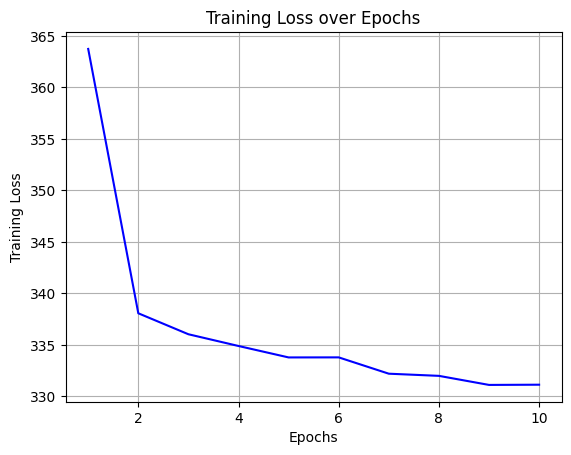

[363.72629462779895, 338.0652894340494, 336.02922956629, 334.88988442822154, 333.77896367343027, 333.7846242961978, 332.2002389034503, 331.99065959855704, 331.1106559578354, 331.13196629970383]


In [41]:
import matplotlib.pyplot as plt

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot the training loss
plt.plot(epochs, train_losses, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

print(train_losses)

In [17]:
from mlp_utils import test_prediction_to_csv

test_prediction_to_csv(predictions, "predicting_six_layer_mlp_call_type_a_min.csv", test_data)